# Convergence of training and test error

According to statistical learning theory a training and test error converges when the number of training samples grows for all **reasonable machine learning methods**. However, the convergence speeds really depends on many factors. The following notebook highlight the differences and causes behind them.    

In [1]:
import numpy as np
import numpy.random as random
import pandas as pd

from pandas import Series
from pandas import DataFrame
from typing import List

# Local imports
from common import *
from convenience import *

## I. Data generation functions 

Code for generating data according to logistic regression model

* The binary data matrix X is generated randomly 
* The target vector y is generated according to logit model

We generate two types of data matices:

* compact matrices where all features are needed for prediction
* matrices with extra columns that do not contain any information for prediction

**Random functions** 

In [17]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def logit(x:Series, w:Series):
    """
    Labels output according to logit model pr[y=1| sigmoid(w*x)]
    
    You can omit trailing zeroes in w by specifying only first non-zero coefficients  
    """
    return random.rand() <= sigmoid(np.dot(x.iloc[0:len(w)] - 0.5, w))

**Data generation**

In [13]:
def data_sampler(n:int, k:int,  f:callable) -> DataFrame:
    """
    Data generator that generates n x k feature matrix and a target vector
    
    Returns a data frame with columns x_1, ..., x_k, y where y is computed
    using ramdomised labelling function f.
    """
    
    columns = ['x_{}'.format(num) for num in range(1, k + 1)]
    return (DataFrame(random.rand(n, k), columns = columns)
            .transform(lambda x: x >= 0.5)
            .assign(y = lambda df: df.apply(f, axis=1)))

## II. Example datasets

* The size of the dataset and nature of the labelling function determines the hardness of the problem
* If target function is near-deterministic then there exist a good predictor
* If the number of features is small then it is easier to learn the target function

###  Choosing among target function

* Lets build a target function that outputs `True` if at least one input is `True`
* The weights `w=[1,1]` achieve this but you will see that relation is not absolute
* Larger weights `[10, 10]` increase certainty and smaller weight `[0.1, 0.1]` decrease certainty

In [8]:
fs = lambda x: logit(x, Series([1, 1]))
X = data_sampler(1000, 2, fs)
X.head()

,x_1,x_2,y
0,False,False,False
1,False,True,False
2,True,True,True
3,False,True,True
4,True,True,True


Let see what is the fraction of `True` values for each input

In [9]:
S = X.groupby(['x_1', 'x_2']).aggregate(['count', 'sum'])
S.columns = S.columns.droplevel(0)  
S = S.assign(freq = lambda df: round(df['sum']/df['count'] * 100))
S.reset_index()

,x_1,x_2,count,sum,freq
0,False,False,262,69.0,26.0
1,False,True,257,126.0,49.0
2,True,False,224,126.0,56.0
3,True,True,257,186.0,72.0


The relation between inputs and outbut is not so clear:
* Lets experiment with different weights to see what happens
* For simplicity convert previous analysis to a function

In [10]:
def summarize(X:DataFrame) -> DataFrame:
    S = X.groupby(['x_1', 'x_2']).aggregate(['count', 'sum'])
    S.columns = S.columns.droplevel(0)  
    return (S.assign(freq = lambda df: round(df['sum']/df['count'] * 100)).
            reset_index())  
display(summarize(X))

,x_1,x_2,count,sum,freq
0,False,False,262,69.0,26.0
1,False,True,257,126.0,49.0
2,True,False,224,126.0,56.0
3,True,True,257,186.0,72.0


To estimate the effect of statistical fluctuations we do two experiments and compare results

In [11]:
X = data_sampler(1000, 2, lambda x: logit(x, Series([10, 10])))
S1 = summarize(X)
X = data_sampler(1000, 2, lambda x: logit(x, Series([10, 10])))
S2 = summarize(X)
mdisplay([S1, S2], ['Sample 1', 'Sample 2'])

X = data_sampler(1000, 2, lambda x: logit(x, Series([0.1, 0.1])))
S1 = summarize(X)
X = data_sampler(1000, 2, lambda x: logit(x, Series([0.1, 0.1])))
S2 = summarize(X)
mdisplay([S1, S2], ['Sample 1', 'Sample 2'])

Sample 1 Sample 2 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 242 
 0.0 
 0.0 
 
 
 False 
 True 
 252 
 130.0 
 52.0 
 
 
 True 
 False 
 247 
 121.0 
 49.0 
 
 
 True 
 True 
 259 
 259.0 
 100.0 
 
 
 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 253 
 0.0 
 0.0 
 
 
 False 
 True 
 245 
 120.0 
 49.0 
 
 
 True 
 False 
 250 
 130.0 
 52.0 
 
 
 True 
 True 
 252 
 252.0 
 100.0

Sample 1 Sample 2 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 246 
 109.0 
 44.0 
 
 
 False 
 True 
 273 
 138.0 
 51.0 
 
 
 True 
 False 
 223 
 119.0 
 53.0 
 
 
 True 
 True 
 258 
 134.0 
 52.0 
 
 
 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 249 
 117.0 
 47.0 
 
 
 False 
 True 
 247 
 116.0 
 47.0 
 
 
 True 
 False 
 245 
 118.0 
 48.0 
 
 
 True 
 True 
 259 
 143.0 
 55.0

**Conclusion:** The number of samples is too small to get an accurate probability estimate

In [12]:
X = data_sampler(100000, 2, lambda x: logit(x, Series([10, 10])))
S1 = summarize(X)
X = data_sampler(100000, 2, lambda x: logit(x, Series([10, 10])))
S2 = summarize(X)
mdisplay([S1, S2], ['Sample 1', 'Sample 2'])

X = data_sampler(100000, 2, lambda x: logit(x, Series([0.1, 0.1])))
S1 = summarize(X)
X = data_sampler(100000, 2, lambda x: logit(x, Series([0.1, 0.1])))
S2 = summarize(X)
mdisplay([S1, S2], ['Sample 1', 'Sample 2'])

Sample 1 Sample 2 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 24887 
 0.0 
 0.0 
 
 
 False 
 True 
 25242 
 12618.0 
 50.0 
 
 
 True 
 False 
 24805 
 12394.0 
 50.0 
 
 
 True 
 True 
 25066 
 25065.0 
 100.0 
 
 
 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 25097 
 0.0 
 0.0 
 
 
 False 
 True 
 25285 
 12658.0 
 50.0 
 
 
 True 
 False 
 24810 
 12403.0 
 50.0 
 
 
 True 
 True 
 24808 
 24808.0 
 100.0

Sample 1 Sample 2 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 24974 
 11846.0 
 47.0 
 
 
 False 
 True 
 25033 
 12561.0 
 50.0 
 
 
 True 
 False 
 24981 
 12415.0 
 50.0 
 
 
 True 
 True 
 25012 
 13130.0 
 52.0 
 
 
 
 
 
 x_1 
 x_2 
 count 
 sum 
 freq 
 
 
 
 
 False 
 False 
 25119 
 11840.0 
 47.0 
 
 
 False 
 True 
 24926 
 12518.0 
 50.0 
 
 
 True 
 False 
 25059 
 12585.0 
 50.0 
 
 
 True 
 True 
 24896 
 13134.0 
 53.0

* Weight vector `w = [10,  10]`  creates predictable instances
* Weight vector `w = [0.1, 0.1]` creates almost unpredictable instances 

### Choosing learning tasks to compare

* Lets consider predictable and almost unpredictable labelling functions
* Lets consider with few and with many features

In [11]:
sampler_11 = lambda n: data_sampler(n, 2, lambda x: logit(x, Series([10, 10])))
sampler_10 = lambda n: data_sampler(n, 2, lambda x: logit(x, Series([0.1, 0.1])))
sampler_01 = lambda n: data_sampler(n, 15, lambda x: logit(x, Series([10, 10])))
sampler_00 = lambda n: data_sampler(n, 15, lambda x: logit(x, Series([0.1, 0.1])))

## III. Learning algorithms

* Lets observe the behaviour of several algorithms
* Majority voting is the simplest and the best classification algorithm:
  * It is optimal if the number of samples is large enough to cover each possible input
  * It is theoretically optimal -- we cannot do better without extra knowledge about the data
* Logistic regression can work with fewer samples:
  * It makes extra assumptions about the labelling function
  * As a result there are fewer parameters to learn
  * The convergence to the final classification algoritm is faster  

###  Majority voting algorithm

* Our implementation corresponds to `sklearn` prediction API:
  * Constructor for fixing free hyperparamaters
  * Method `fit(samples, targets)` to train the model
  * Method `predict(samples)` to predict labels
  * Method `set_params(...)` to set hyperparamaters  

In [9]:
class MajorityVoting:
    
    def __init__(self, features:List[str]=None):
        if features:
            self.features = list(features)
        else:
            self.features = None
    
    def set_params(features: List[str]) -> None:
        self.features = features
    
    def fit(self, X: DataFrame, y: Series) -> None:
        
        if self.features is None:
            self.features = list(X.columns.values)

        data = X.assign(y = y)
        pred = data.groupby(self.features).aggregate(['count', 'sum'])
        pred.columns = pred.columns.droplevel(0)
        self.pred = DataFrame({'prediction':(pred['sum']/pred['count'] >= 0.5)})
    
    def predict(self, X: DataFrame) -> np.array:
        
        return (X[self.features]
                .join(self.pred, on=self.features, how='left')['prediction']
                .fillna(True)
                .values)

**Majority voting:** Example run

In [18]:
clf = MajorityVoting()
data = sampler_11(2)
features = list(data.columns.values)[0:-1]
clf.fit(data[features], data['y'])
mdisplay([data, clf.pred],['Data', 'Predictor'])

Data Predictor 
 
 
 x_1 
 x_2 
 y 
 
 
 
 
 False 
 False 
 False 
 
 
 True 
 False 
 True 
 
 
 
 
 
 prediction 
 
 
 
 
 False 
 
 
 True

**Logistic regression:** Example run

In [20]:
from sklearn.linear_model import LogisticRegression
data = sampler_11(2)

clf = LogisticRegression(solver = 'lbfgs')
features = list(data.columns.values)[0:-1]
clf.fit(data[features], data['y'])
clf.predict(data[features])

array([ True, False])

## IV.  Convergence plots for accuracy

* We generate different datasets for different sizes and estimate classifiers performance on the test set
* To eliminate fluctuations based on test data generation we use same testset for all training set sizes  

### Generation of training and test data

In [21]:
sizes = [10, 50, 100] + list(range(200, 1001, 100)) + list(range(2000, 5001, 1000))

train_00 = [sampler_00(n) for n in sizes]
features_00 = list(train_00[0].columns.values[0:-1])

train_01 = [sampler_01(n) for n in sizes]
features_01 = list(train_01[0].columns.values[0:-1])

train_10 = [sampler_10(n) for n in sizes]
features_10 = list(train_10[0].columns.values[0:-1])

train_11 = [sampler_11(n) for n in sizes]
features_11 = list(train_11[0].columns.values[0:-1])

n = 10000
test_00 = sampler_00(n)
test_01 = sampler_01(n)
test_10 = sampler_10(n)
test_11 = sampler_11(n)

### Majority Voting example  

It always easier to to the analysis for one dataset to work out the details

In [22]:
test = test_11
train = train_11[1]
clf = MajorityVoting(features_11)
clf.fit(train, train['y'])
display(clf.pred)

prediction
x_1   x_2              
False False       False
      True        False
True  False        True
      True         True

In [23]:
mdisplay([train.head(), DataFrame(clf.predict(train)).head()], ['Data', 'Prediction'])

Data Prediction 
 
 
 x_1 
 x_2 
 y 
 
 
 
 
 False 
 True 
 False 
 
 
 True 
 False 
 True 
 
 
 False 
 True 
 False 
 
 
 True 
 False 
 False 
 
 
 False 
 False 
 False 
 
 
 
 
 
 0 
 
 
 
 
 False 
 
 
 True 
 
 
 False 
 
 
 True 
 
 
 False

In [24]:
test_error = sum(test['y'] != clf.predict(test)) / len(test) * 100
training_error = sum(train['y'] != clf.predict(train)) / len(train) * 100
print('Training error: {tr}% \nTest error:     {te}%'.format(tr=round(training_error), te=round(test_error)))

Training error: 24% 
Test error:     25%


### Logistic regression example

In [25]:
test = test_11
train = train_11[1]
clf = LogisticRegression(solver = 'lbfgs')
clf.fit(train[features_11], train['y'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [30]:
test_error = sum(test['y'] != clf.predict(test[features_11])) / len(test) * 100
training_error = sum(train['y'] != clf.predict(train[features_11])) / len(train) * 100
print('Training error: {tr}% \nTest error:     {te}%'.format(tr=round(training_error), te=round(test_error)))

Training error: 23% 
Test error:     25%


### Complete analysis

Lets generate multi-indexed key-value dataframe for storing errors 

In [53]:
df = (combine_categories({'method': ['MV', 'LR'], 'size': sizes, 'type': ['test', 'train']})
      .assign(error=np.nan, accuracy=np.nan))

error = (pd.concat([
         df.assign(source = '00', fit = 'bad',  dim = 'large'),
         df.assign(source = '01', fit = 'good', dim = 'large'),
         df.assign(source = '10', fit = 'bad',  dim = 'small'),
         df.assign(source = '11', fit = 'good', dim = 'small')])
         .set_index(['method', 'size', 'type', 'source']))[['dim', 'fit', 'error', 'accuracy']]

error = error.sort_index()
display(error.head())

dim   fit  error  accuracy
method size type  source                              
LR     10   test  00      large   bad    NaN       NaN
                  01      large  good    NaN       NaN
                  10      small   bad    NaN       NaN
                  11      small  good    NaN       NaN
            train 00      large   bad    NaN       NaN

Iterate over all datasets and fill the table for majority voting

In [54]:
for i, size in enumerate(sizes):
    test = test_00
    train = train_00[i]
    clf = MajorityVoting(features_00)
    clf.fit(train, train['y'])
    error.loc[('MV',size,'test' ,'00'), 'error'] = sum(test['y'] != clf.predict(test)) / len(test) * 100
    error.loc[('MV',size,'train','00'), 'error'] = sum(train['y'] != clf.predict(train)) / len(train) * 100
    
    test = test_01
    train = train_01[i]
    clf = MajorityVoting(features_01)
    clf.fit(train, train['y'])
    error.loc[('MV',size,'test', '01'), 'error'] = sum(test['y'] != clf.predict(test)) / len(test) * 100
    error.loc[('MV',size,'train','01'), 'error'] = sum(train['y'] != clf.predict(train)) / len(train) * 100

    test = test_10
    train = train_10[i]
    clf = MajorityVoting(features_10)
    clf.fit(train, train['y'])
    error.loc[('MV',size,'test', '10'), 'error'] = sum(test['y'] != clf.predict(test)) / len(test) * 100
    error.loc[('MV',size,'train','10'), 'error'] = sum(train['y'] != clf.predict(train)) / len(train) * 100

    test = test_11
    train = train_11[i]
    clf = MajorityVoting(features_11)
    clf.fit(train, train['y'])
    error.loc[('MV',size,'test', '11'), 'error'] = sum(test['y'] != clf.predict(test)) / len(test) * 100
    error.loc[('MV',size,'train','11'), 'error'] = sum(train['y'] != clf.predict(train)) / len(train) * 100

display(error.loc['MV', 'error'].unstack())  

source             00         01         10         11
size type                                             
10   test   50.040000  49.250000  49.190000  49.480000
     train   0.000000   0.000000  20.000000  20.000000
50   test   50.020000  49.190000  50.120000  25.000000
     train   0.000000   0.000000  36.000000  24.000000
100  test   50.100000  49.230000  49.040000  25.000000
     train   0.000000   0.000000  40.000000  22.000000
200  test   50.020000  49.180000  50.810000  24.890000
     train   0.000000   0.000000  42.000000  21.500000
300  test   50.100000  49.150000  50.210000  24.970000
     train   1.333333   0.000000  45.666667  24.000000
400  test   50.080000  49.010000  50.900000  24.890000
     train   0.750000   0.000000  47.250000  23.500000
500  test   50.020000  48.970000  49.880000  25.080000
     train   0.200000   0.200000  47.600000  23.000000
600  test   50.070000  48.820000  49.190000  24.970000
     train   0.666667   0.666667  45.666667  24.833333
700  test   49.870000  48.730000  49.250000  25.000000
     train   0.285714   0.142857  46.285714  21.714286
800  test   49.810000  48.700000  49.190000  25.000000
     train   0.250000   0.250000  45.250000  22.000000
900  test   50.150000  48.700000  49.190000  25.000000
     train   0.333333   0.222222  46.111111  23.555556
1000 test   49.870000  48.420000  49.190000  25.000000
     train   0.700000   0.700000  47.700000  23.500000
2000 test   49.920000  47.720000  49.040000  24.970000
     train   1.300000   0.900000  46.450000  23.750000
3000 test   49.870000  47.360000  49.250000  25.000000
     train   2.033333   1.266667  47.433333  24.166667
4000 test   49.790000  46.480000  49.190000  24.970000
     train   3.125000   1.575000  47.375000  24.175000
5000 test   50.210000  45.910000  49.190000  25.080000
     train   3.580000   1.600000  49.020000  24.640000

In [58]:
for i, size in enumerate(sizes):
    test = test_00
    train = train_00[i]
    features = features_00 
    clf = LogisticRegression(solver = 'lbfgs')
    clf.fit(train[features], train['y'])  
    error.loc[('LR',size,'test', '00'), 'error'] = sum(test['y'] != clf.predict(test[features])) / len(test) * 100
    error.loc[('LR',size,'train','00'), 'error'] = sum(train['y'] != clf.predict(train[features])) / len(train) * 100

    test = test_01
    train = train_01[i]
    features = features_01 
    clf = LogisticRegression(solver = 'lbfgs')
    clf.fit(train[features], train['y'])    
    error.loc[('LR',size,'test', '01'), 'error'] = sum(test['y'] != clf.predict(test[features])) / len(test) * 100
    error.loc[('LR',size,'train','01'), 'error'] = sum(train['y'] != clf.predict(train[features])) / len(train) * 100

    test = test_10
    train = train_10[i]
    features = features_10 
    clf = LogisticRegression(solver = 'lbfgs')
    clf.fit(train[features], train['y'])    
    error.loc[('LR',size,'test', '10'), 'error'] = sum(test['y'] != clf.predict(test[features])) / len(test) * 100
    error.loc[('LR',size,'train','10'), 'error'] = sum(train['y'] != clf.predict(train[features])) / len(train) * 100

    test = test_11
    train = train_11[i]
    features = features_11 
    clf = LogisticRegression(solver = 'lbfgs')
    clf.fit(train[features], train['y'])    
    error.loc[('LR',size,'test', '11'), 'error'] = sum(test['y'] != clf.predict(test[features])) / len(test) * 100
    error.loc[('LR',size,'train','11'), 'error'] = sum(train['y'] != clf.predict(train[features])) / len(train) * 100

display(error.loc['LR', 'error'].unstack())

source             00         01         10         11
size type                                             
10   test   50.280000  30.450000  49.190000  49.370000
     train  10.000000   0.000000  20.000000  30.000000
50   test   49.290000  25.590000  50.120000  25.000000
     train  26.000000  12.000000  36.000000  24.000000
100  test   49.180000  24.710000  49.040000  25.000000
     train  32.000000  13.000000  40.000000  22.000000
200  test   50.220000  25.010000  50.810000  24.890000
     train  38.000000  20.000000  42.000000  21.500000
300  test   49.840000  25.020000  49.190000  25.080000
     train  43.333333  17.000000  46.333333  24.000000
400  test   49.440000  24.260000  49.880000  24.890000
     train  38.750000  19.750000  47.500000  23.500000
500  test   49.580000  24.380000  49.940000  25.080000
     train  46.400000  19.800000  47.800000  23.000000
600  test   49.920000  24.580000  49.190000  24.970000
     train  41.000000  21.333333  45.666667  24.833333
700  test   48.150000  24.960000  49.250000  25.000000
     train  42.571429  22.142857  46.285714  21.714286
800  test   50.160000  24.630000  49.190000  25.000000
     train  43.875000  23.000000  45.250000  22.000000
900  test   49.010000  25.170000  49.250000  25.000000
     train  46.777778  21.666667  46.333333  23.555556
1000 test   49.310000  24.520000  49.190000  25.000000
     train  46.100000  22.100000  47.700000  23.500000
2000 test   49.690000  25.040000  49.040000  24.970000
     train  46.000000  21.800000  46.450000  23.750000
3000 test   47.930000  24.840000  49.190000  25.000000
     train  45.433333  22.266667  48.133333  24.166667
4000 test   48.830000  24.360000  49.190000  24.970000
     train  47.100000  24.075000  47.375000  24.175000
5000 test   48.900000  24.340000  49.190000  25.080000
     train  47.880000  24.440000  49.020000  24.640000

Add accuracy for clarity and save the result

In [59]:
error = error.assign(error = lambda df: round(df['error'], 2), accuracy = lambda df: round(100 - df['error'], 2)).reset_index()
error.to_csv('results/convergence.csv', index = False)

### Display results

We plot two graphs. One for large-scale asymptotic behaviour and one for small-scale behaviour:

* The first shows overall convergence
* The second shows what happens in the beginning

To make out life easier we use `ggplot` grammar of graphics for specifying what we want

In [60]:
from plotnine import *

In [126]:
# Order facet dimensions
from pandas.api.types import CategoricalDtype
DimType = CategoricalDtype(['small', 'large'], ordered = True)
FitType = CategoricalDtype(['good', 'bad'], ordered = True)
df = error.assign(fit = error['fit'].astype(FitType), dim = error['dim'].astype(DimType))

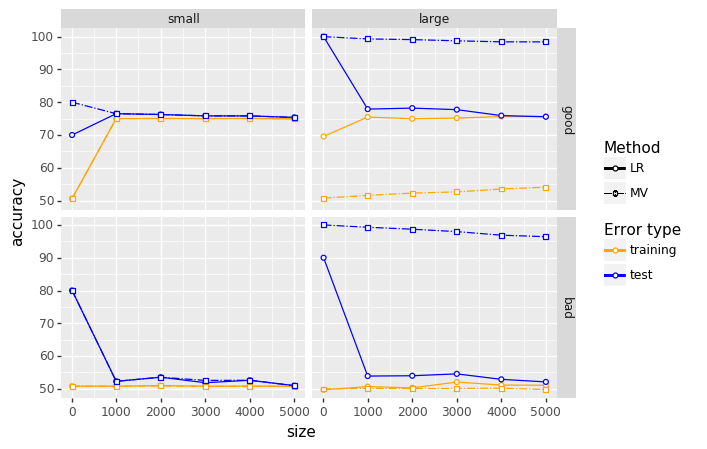

<ggplot: (-9223372029305172287)>

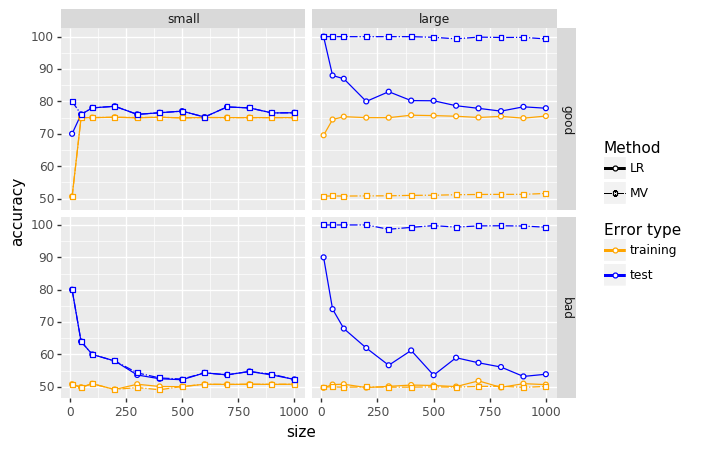

<ggplot: (-9223372029305443808)>

In [128]:
# Large-scale plot
p = ggplot(data = df.loc[error['size'].isin([10, 1000, 2000, 3000, 4000, 5000]),:])
p = p + geom_line(aes(x='size', y='accuracy', linetype='method', color='type'))
p = p + geom_point(aes(x='size', y='accuracy', shape='method', color='type'), fill = 'white')
p = p + facet_grid(['fit', 'dim'])
p = p + scale_shape_manual(name='Method',values=['o', 's'], labels=['LR','MV'])
p = p + scale_linetype_manual(name = 'Method', values=['-', '-.'], labels=['LR','MV']) 
p = p + scale_color_manual(name='Error type',   values=['orange', 'blue'], labels=['training','test'])
p.save('convergence-large.pdf', path='results', height=6, width=12, verbose=False)
display(p)

# Small-scale plot
p = ggplot(data = df.loc[error['size'] <= 1000,:])
p = p + geom_line(aes(x='size', y='accuracy', linetype='method', color='type'))
p = p + geom_point(aes(x='size', y='accuracy', shape='method', color='type'), fill = 'white')
p = p + facet_grid(['fit', 'dim'])
p = p + scale_shape_manual(name='Method',values=['o', 's'], labels=['LR','MV'])
p = p + scale_linetype_manual(name = 'Method', values=['-', '-.'], labels=['LR','MV']) 
p = p + scale_color_manual(name='Error type',   values=['orange', 'blue'], labels=['training','test'])
p.save('convergence-small.pdf', path='results', height=6, width=12, verbose=False)
display(p)

# Homework tasks

## 1.1 Classifier that minimises empirical risk (<font color='red'>1p</font>)

Given enough information about future data samples, it is possible to find a class with optimal accuracy.
The corresponding construction `MajorityVoting` was given above for the binary classification task.
* Extend the solution for multi-label classification task and apply it to the dataframe `data` below.
* Predict `z` for  `x` and `y` and show the corresponding table of rules.
* What is the corresponding risk if it is defined as the probability of misclassification on `data`? 

In [17]:
data = (DataFrame([(0, 0, 0), (0, 0, 1), (0, 0, 1), (0, 1, 2), (0, 1, 2),
                  (1, 0, 1), (1, 0, 0), (1, 0, 2), (2, 0, 1), 
                  (2, 1, 0), (2, 1, 0), (2, 1, 0), 
                  (3, 1, 1), (3, 1, 1), (3, 1, 1), (3, 1, 2)], columns = ['x', 'y', 'z'])
        .sample(frac=1).reset_index(drop = True))
display(data.head())

,x,y,z
0,3,1,1
1,2,1,0
2,2,0,1
3,1,0,0
4,2,1,0


## 1.2 Visualise statistical fluctuations (<font color='red'>1p</font>)

The visualisations constructed above are built based on a single run where for each size we have sampled a single dataset form a datasource (**distribution**). 
As such the figure fails to capture the effect of statistical fluctuations, i.e., what is the effect of sampling to the results.
* Modify the code of the experiment so that 10 experiments are done for each dataset size.
* Show different scores in the graph and compute the average score line.
  For clarity you can do separate plots for majority voting and logistic regression.
* Justify decisions you made in the experiment design and interpret obtained results.

## 1.3 Optimise the data generation process* (<font color='red'>1p</font>)

The data generation procedure is slow as it does not use `numpy` matrix operations.
Fix this issue and measure the speedup.

## 1.4. Theoretical analysis of majority voting* (<font color='red'>3p</font>) 

Explain why the training accuracy is so high for majority voting. 
You can give a theoretical answer or design an experiment to answer the following questions. 
You can consider the extreme case where the features $x_i$ and labels $y$ are sampled randomly. 

* Give a rough estimate how many samples are needed to arrive to the situation where training error is roughly the same as test error. 
 
* How does the sample size depend on the number of dimensions? 
* What changes if some feature values are more probable than the others? 